## Librerias

In [44]:
import pandas as pd
import urllib.request
from PIL import Image
import ML_ToolBox as tb
from sklearn.model_selection import train_test_split,  GridSearchCV
import bootcampviztools as vt
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
from catboost import CatBoostRegressor

## Data

In [2]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("data/train.csv", index_col = 0)
df.index.name = None

## Data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


## Data processing

El target es la columna `Price_in_euros`

In [5]:
tb.describe_df(df)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
Data_Type,object,object,object,float64,object,object,object,object,object,object,object,float64
Missings(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unique_Values,19,480,6,17,36,107,9,37,93,9,165,603
Card(%),2.08,52.63,0.66,1.86,3.95,11.73,0.99,4.06,10.2,0.99,18.09,66.12


In [6]:
df["ram_GB"] = df["Ram"].str.replace("GB", "").astype(int)
df["weight_kg"] = df["Weight"].str.replace("kg", "").astype(float)



In [7]:
memory_split = df['Memory'].str.extract(r'(\d+)\s*([A-Za-z]+)\s*([A-Za-z]+)')
df['memory_type'] = memory_split[2]
df['capacity_gb'] = memory_split[0].astype(int)


In [8]:
df['capacity_gb'] = df.apply(lambda row: row['capacity_gb'] * 1000 if row['capacity_gb'] < 5 else row['capacity_gb'], axis=1)


In [9]:
cpu_split = df['Cpu'].str.extract(r'(Intel|AMD).*?(\d+(\.\d+)?GHz)')

df['cpu_brand'] = cpu_split[0]
df['cpu_speed'] = cpu_split[1].str.replace("GHz","").astype(float)


In [10]:
resolution_split = df['ScreenResolution'].str.extract(r'(?P<panel_type>.+?)\s*(?P<resolution>\d+x\d+)')
df['panel_type'] = resolution_split['panel_type']
df['resolution'] = resolution_split['resolution']
df.loc[df['panel_type'] == '1', 'panel_type'] = 'SD'

In [11]:
df.panel_type.value_counts()

panel_type
Full HD                                349
SD                                     231
IPS Panel Full HD                      167
IPS Panel Full HD / Touchscreen         32
Full HD / Touchscreen                   30
Touchscreen                             24
IPS Panel Retina Display                12
Quad HD+ / Touchscreen                  11
IPS Panel 4K Ultra HD / Touchscreen     10
IPS Panel Touchscreen                    8
4K Ultra HD / Touchscreen                7
IPS Panel                                7
IPS Panel Quad HD+ / Touchscreen         6
IPS Panel 4K Ultra HD                    5
IPS Panel Quad HD+                       4
4K Ultra HD                              3
Quad HD+                                 2
Touchscreen / Quad HD+                   1
2                                        1
Touchscreen / 4K Ultra HD                1
Touchscreen / Full HD                    1
Name: count, dtype: int64

In [12]:
fila_panel_type_2 = df.loc[df['panel_type'] == '2']
fila_panel_type_2.loc[fila_panel_type_2.index, 'resolution'] = '2560x1440'
fila_panel_type_2.loc[fila_panel_type_2.index, 'panel_type'] = 'Full HD'



In [13]:
df.drop(["ScreenResolution", "Cpu", "Memory", "Weight", "Ram"], axis= 1, inplace= True)

In [14]:
df

,Company,Product,TypeName,Inches,Gpu,OpSys,Price_in_euros,ram_GB,weight_kg,memory_type,capacity_gb,cpu_brand,cpu_speed,panel_type,resolution
755,HP,250 G6,Notebook,15.6,Intel HD Graphics 520,Windows 10,539.00,8,1.86,SSD,256,Intel,2.0,Full HD,1920x1080
618,Dell,Inspiron 7559,Gaming,15.6,Nvidia GeForce GTX 960<U+039C>,Windows 10,879.01,16,2.59,HDD,1000,Intel,2.6,Full HD,1920x1080
909,HP,ProBook 450,Notebook,15.6,Nvidia GeForce 930MX,Windows 10,900.00,8,2.04,HDD,1000,Intel,2.7,Full HD,1920x1080
2,Apple,Macbook Air,Ultrabook,13.3,Intel HD Graphics 6000,macOS,898.94,8,1.34,Flash,128,Intel,1.8,SD,440x900
286,Dell,Inspiron 3567,Notebook,15.6,AMD Radeon R5 M430,Linux,428.00,4,2.25,HDD,1000,Intel,2.0,Full HD,1920x1080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,Notebook,15.6,AMD Radeon 530,Windows 10,800.00,8,2.20,SSD,256,Intel,1.6,Full HD,1920x1080
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Intel HD Graphics 520,Windows 10,1629.00,8,1.48,SSD,256,Intel,2.4,Full HD / Touchscreen,1920x1080
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Intel HD Graphics 620,No OS,519.00,8,2.20,HDD,2000,Intel,2.5,Full HD,1920x1080
23,HP,255 G6,Notebook,15.6,AMD Radeon R2,No OS,258.00,4,1.86,HDD,500,AMD,1.5,SD,366x768


-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [15]:
X = df.drop(['Price_in_euros'], axis=1)
y = df['Price_in_euros'].copy()
X.shape

(912, 14)

In [16]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [18]:
X_train

,Company,Product,TypeName,Inches,Gpu,OpSys,ram_GB,weight_kg,memory_type,capacity_gb,cpu_brand,cpu_speed,panel_type,resolution
1118,HP,ZBook 17,Workstation,17.3,AMD FirePro W6150M,Windows 7,8,3.00,HDD,1000,Intel,2.6,IPS Panel Full HD,1920x1080
153,Dell,Inspiron 5577,Gaming,15.6,Nvidia GeForce GTX 1050,Windows 10,16,2.56,SSD,512,Intel,2.8,Full HD,1920x1080
275,Apple,MacBook Pro,Ultrabook,13.3,Intel Iris Graphics 550,macOS,8,1.37,SSD,512,Intel,2.9,IPS Panel Retina Display,2560x1600
1100,HP,EliteBook 840,Notebook,14.0,Intel HD Graphics 520,Windows 7,4,1.54,HDD,500,Intel,2.3,Full HD,1920x1080
131,Dell,Inspiron 5770,Notebook,17.3,AMD Radeon 530,Windows 10,16,2.80,SSD,256,Intel,1.8,Full HD,1920x1080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,HP,14-am079na (N3710/8GB/2TB/W10),Notebook,14.0,Intel HD Graphics 405,Windows 10,8,1.94,HDD,2000,Intel,1.6,SD,366x768
996,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,AMD Radeon 530,Windows 10,6,2.20,SSD,256,AMD,3.6,Full HD,1920x1080
770,Dell,Latitude 7280,Ultrabook,12.5,Intel HD Graphics 620,Windows 10,16,1.18,SSD,256,Intel,2.8,Full HD,1920x1080
407,Lenovo,IdeaPad 320-15IAP,Notebook,15.6,Intel HD Graphics 500,Windows 10,4,2.20,HDD,1000,Intel,1.1,SD,366x768


In [19]:
features_num = df.select_dtypes(include=['int', 'float']).columns.to_list()
features_num.remove("Price_in_euros")
features_cat = df.select_dtypes(include= ["object"]).columns.to_list()


In [20]:
features_cat

['Company',
 'Product',
 'TypeName',
 'Gpu',
 'OpSys',
 'memory_type',
 'cpu_brand',
 'panel_type',
 'resolution']

array([[<Axes: title={'center': 'Inches'}>,
        <Axes: title={'center': 'ram_GB'}>],
       [<Axes: title={'center': 'weight_kg'}>,
        <Axes: title={'center': 'capacity_gb'}>],
       [<Axes: title={'center': 'cpu_speed'}>, <Axes: >]], dtype=object)

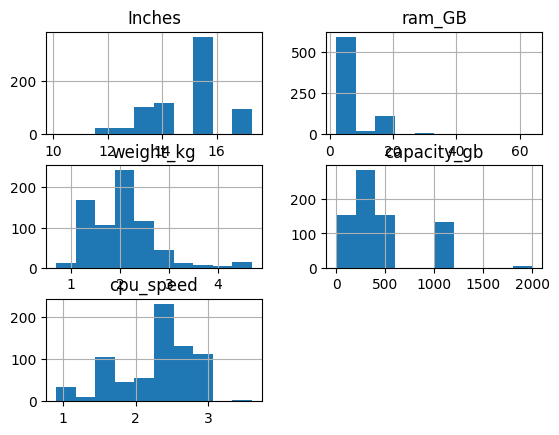

In [21]:
X_train[features_num].hist()

In [22]:
X_train_scal = X_train.copy()
X_test_scal = X_test.copy()

In [23]:
X_train_scal = pd.get_dummies(X_train_scal, columns= features_cat, dtype= int)
X_test_scal = pd.get_dummies(X_test_scal, columns= features_cat, dtype= int)

In [24]:
scaler = StandardScaler()
X_train_scal[features_num] = scaler.fit_transform(X_train_scal[features_num])
X_test_scal[features_num] = scaler.transform(X_test_scal[features_num])

In [25]:
X_train_scal

,Inches,ram_GB,weight_kg,capacity_gb,cpu_speed,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,resolution_2560x1440,resolution_2560x1600,resolution_2880x1800,resolution_3200x1800,resolution_366x768,resolution_3840x2160,resolution_440x900,resolution_560x1440,resolution_600x900,resolution_920x1080
1118,1.608931,-0.046800,1.447238,1.693520,0.624487,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0.418230,1.558700,0.788210,0.256967,1.012497,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
275,-1.192719,-0.046800,-0.994161,0.256967,1.206502,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1100,-0.702430,-0.849549,-0.739537,0.221642,0.042473,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,1.608931,1.558700,1.147680,-0.496635,-0.927550,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-0.702430,-0.046800,-0.140420,4.637275,-1.315559,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
996,0.418230,-0.448174,0.249005,-0.496635,2.564534,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
770,-1.753048,1.558700,-1.278742,-0.496635,1.012497,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
407,0.418230,-0.849549,0.249005,1.693520,-2.285583,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### 3. Baseline de modelos


In [51]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)
cat_reg = CatBoostRegressor(iterations=150,
                          learning_rate=1,
                          depth=10)
modelos_reg = {
    "Random Forest": rf_reg,
    "Cat Boost": cat_reg,
    #"XGBoost Regressor": xgb_reg
}

for tipo, modelo in modelos_reg.items():
    scores = cross_val_score(modelo, X_train_scal, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{tipo}: {rmse_scores.mean()}")

Random Forest: 296.3752154185106
0:	learn: 371.6475542	total: 12.3ms	remaining: 1.83s
1:	learn: 332.5224571	total: 23.6ms	remaining: 1.75s
2:	learn: 285.2679357	total: 35.5ms	remaining: 1.74s
3:	learn: 262.3762120	total: 47.5ms	remaining: 1.73s
4:	learn: 229.6536518	total: 58.5ms	remaining: 1.7s
5:	learn: 225.2172730	total: 69.7ms	remaining: 1.67s
6:	learn: 211.2165126	total: 82.1ms	remaining: 1.68s
7:	learn: 199.0445965	total: 93.6ms	remaining: 1.66s
8:	learn: 192.0521412	total: 105ms	remaining: 1.65s
9:	learn: 175.4002919	total: 116ms	remaining: 1.63s
10:	learn: 170.9173995	total: 128ms	remaining: 1.62s
11:	learn: 165.8655800	total: 140ms	remaining: 1.6s
12:	learn: 162.7457407	total: 152ms	remaining: 1.6s
13:	learn: 153.2505734	total: 164ms	remaining: 1.59s
14:	learn: 142.9153910	total: 175ms	remaining: 1.58s
15:	learn: 140.1089158	total: 186ms	remaining: 1.56s
16:	learn: 135.2826052	total: 199ms	remaining: 1.56s
17:	learn: 132.9484932	total: 211ms	remaining: 1.55s
18:	learn: 129.033

In [31]:
#metrica = RMSE
# Probar con todos,
# Cross validation
# quedarme con los mejores
# Grid Search
# optimización

rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
ltb_reg = LGBMRegressor(max_depth=10, random_state=42, verbose=-100)
xgb_reg = xgb.XGBRegressor(max_depth=10, random_state=42)
log_reg = LogisticRegression()
grad_reg = GradientBoostingRegressor()

modelos_reg = {
    "Random Forest": rf_reg,
    #"XGBoost Regressor": xgb_reg,
    "Logistic Regression": log_reg,
    #"Gradient Boosting": grad_reg
}

for tipo, modelo in modelos_reg.items():
    scores = cross_val_score(modelo, X_train_scal, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{tipo}: {rmse_scores.mean()}")

Random Forest: 296.3752154185106


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    check_classification_targets(y)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py", line 216, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de RMSE.

In [ ]:
#from sklearn.metrics import mean_squared_error (mse)
# y_predict = model.predict(x_test)
# mse = mean_squared_error(y_test, y_predict) 
# RMSE = np.sqrt(mse)


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [ ]:
X_pred = pd.read_csv("data/test.csv", index_col= 0)
X_pred.index.name = None 
X_pred.head()

# Hacer las mismas transformaciones que en el df de train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [ ]:
X_pred.shape

(391, 11)

In [ ]:
predictions_submit = model.predict(X_pred)
predictions_submit

NameError: name 'model' is not defined

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

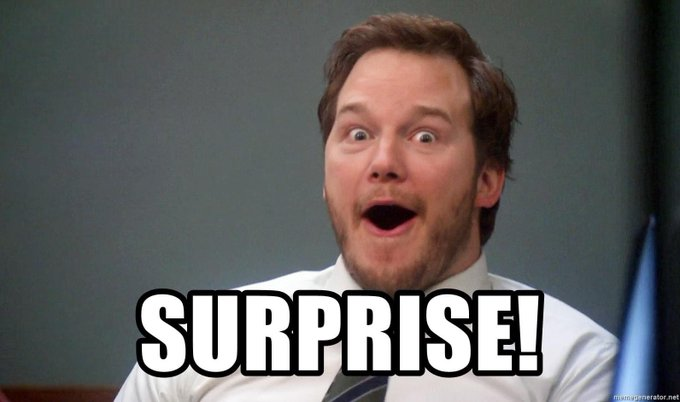

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("data/sample_submission.csv")

In [ ]:
sample.head()

,id,Price_euros
0,1184,2158
1,815,511
2,1244,5290
3,1121,622
4,443,1140


In [ ]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [ ]:
submission = pd.DataFrame({"laptop_ID": X_pred.index, "Price_in_euros": predictions_submit})

In [ ]:
submission.head()

,id,Price_euros
0,1184,2158
1,815,511
2,1244,5290
3,1121,622
4,443,1140


In [ ]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [ ]:
chequeador(submission)

You're ready to submit!
